# SIMULACIÓ DE QUANTUM ANNEALING
Robert Vila Alsina,

Primavera 2023

Pràctiques d'empresa, 

Tutors: Bruno Julià i Carles Calero

Agraïments a Bruno Julià, Carles Calero, Paula Pertegaz i Irene Agudo per tot el feedback.



## Introducció

L'objectiu d'aquest codi i explicacions és entendre la física darrere del quantum annealing i com podem traduïr un problema per a resoldre'l amb aquest procediment. També vol ser una guia per qualsevol persona que es vulgui introduïr en aquest tema i la seva simulació computacional.


## Quantum Annealing

Aquesta forma de computació quàntica utilitza el Teorema Adiabàtic per a evolucionar el Hamiltonià d'un conjunt de qubits en el temps fins a trobar l'estat de mínima energia. Al principi, s'aplica un camp molt fort en la direcció transversal x que força els spins cap a una direcció. El camp transversal es va reduint de forma adiabàtica i al final obtenim el ground state. 

L'Hamiltonià del sistema es pot expressar:

$$ \mathcal{H}(t)=\mathcal{H}_0-\Gamma(t) \sum_i \sigma_i^x $$
on:
$$ \mathcal{H}_0=-\sum_{i,j} J_{i j} \sigma_i^z \sigma_j^z-\alpha \sum_i \sigma_i^z$$

La idea és començar amb una $\Gamma (t)$ molt gran i anar-la reduïnt poc a poc, de manera adabàtica. Això correspon al camp transversal x que apliquem als qubits. Després de l'evolució, l'únic terme que quedarà serà el $\mathcal{H}_0$, que ens permetrà trobar quina és l'energia associada al groundstate.

La importància d'aquesta tècnica de computació quàntica és que es pot fer servir com a eina per a resoldre problemes d'optimització de combinatòria. Això es pot fer expressant el problema com un Hamiltonià d'un model d'Ising i trobant un anàleg en el conjunt de qubits i les seves connexions. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np


### Nombre d'spins
Elegim el nombre d'spins del sistema N que volem simular

In [2]:
N = 4

### Possibles estats
El nombre d'estats del sistema creix com $2^N$ on N és el nombre de bits del sistema. Això fa que per un nombre mitjanament gran de spins no sigui possible computar tots els estats per a trobar el de mínima energia.


[[-1. -1. -1. -1.]
 [-1. -1. -1.  1.]
 [-1. -1.  1. -1.]
 [-1. -1.  1.  1.]
 [-1.  1. -1. -1.]
 [-1.  1. -1.  1.]
 [-1.  1.  1. -1.]
 [-1.  1.  1.  1.]
 [ 1. -1. -1. -1.]
 [ 1. -1. -1.  1.]
 [ 1. -1.  1. -1.]
 [ 1. -1.  1.  1.]
 [ 1.  1. -1. -1.]
 [ 1.  1. -1.  1.]
 [ 1.  1.  1. -1.]
 [ 1.  1.  1.  1.]]
Tindrem un total de: 16 estats


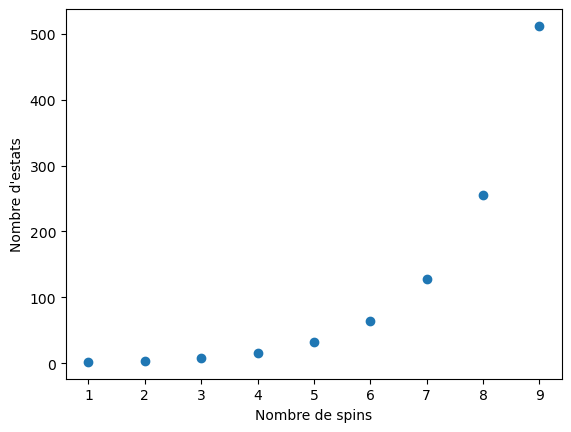

In [3]:
#Fem una matriu amb tots els possibles estats dels spins (2^N)
#En una matriu de N columnes i 2^N files

def matriu_estats(N):
    matriu = np.zeros((2**N,N))
    for i in range(2**N):
        for j in range(N):
            matriu[i,j] = (i // 2**(N-j-1)) % 2
    matriu[matriu == 0] = -1
    return matriu

estats_spins = matriu_estats(N)
print(estats_spins)

print("Tindrem un total de:", len(estats_spins), "estats")

#Grafiquem el nombre d'estats en funció del nombre de spins
x = np.arange(1,10)
y = 2**x
plt.plot(x,y, "o")
plt.xlabel("Nombre de spins")
plt.ylabel("Nombre d'estats")
plt.show()

### Termes d'interacció entre els spins
Per altra banda, la matriu $J_{ij}$ és el patró de interaccions entre els spins. Així, $J_{13}$ mesurarà les interaccions de l'spin 1 amb el 3. Una possible aproximació podria ser considerar que cada spin només interactua amb els dels seu voltant, els primers veïns, de forma que només quedarien diferents de zero la diagonal per sobre de la diagonal principal i la seva simètrica.

En el nostre cas, com que només ens interessa veure com se simula el procés, aleatoritzarem els valors de la matriu. Això ho farem agafant valors d'una distribució Gaussiana de mitjana 0 i desviació estàndard 1.

In [4]:
#Declarem la matriu J d'interacció entre diferents spins
matrix_J = np.random.normal(loc=0, scale=1, size=(N, N))
matrix_J[np.diag_indices(N)] = 0


matrix_J

array([[ 0.        ,  1.262412  , -0.88574293, -1.51098846],
       [-1.04769093,  0.        , -0.53580563, -1.39614418],
       [ 1.70829097,  0.48337629,  0.        , -0.61333751],
       [-2.5533753 , -0.79068887, -0.25609401,  0.        ]])

### Terme d'interacció amb si mateix

També existeix un terme energètic associat al propi spin, $\alpha$. Per exemple, podem posar $\alpha = 1$

In [5]:
#Declarem el terme d'interacció amb si mateix, alpha
alpha = 1
alpha

1

### Hamiltonià inicial del sistema

Amb el nombre d'spins amb el que treballem, podem trobar quin és el ground state abans de simular l'evolució temporal del sistema. Això ho podem fer amb els valors propis. 

El Hamiltonià final del sistema:

$$ \mathcal{H}_0=-\sum_{i,j} J_{i j} \sigma_i^z \sigma_j^z-\alpha \sum_i \sigma_i^z$$

On $\sigma_i^z$ és la matriu de Pauli en la direcció z que actua en l'spin i. És important notar que els termes del sumatori tenen productes tensorials per una identitat 2x2 implícits en totes les posicions que no estem aplicant la matriu de Pauli. Per exemple, el terme d'interacció entre els spins 2 i 3 d'un sistema de 5 bits serà:

$$J_{23}( I \otimes \sigma^z \otimes \sigma^z \otimes I \otimes I )$$

Matrius\\

$I =$ 
\begin{pmatrix}
1 & 0\\
0 & 1
\end{pmatrix}\hspace{2cm}

$$ \sigma^z = $$ 

\begin{pmatrix}
0 & 1\\
1 & 0
\end{pmatrix}\hspace{2cm}

$$\sigma^x =$$ 
\begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}


Energies de l'estat inicial:  [-5.36133359 -4.97775568 -4.97775568 -2.39016542 -1.36133359 -0.58903208
 -0.32039329  0.34053109  0.41398148  0.41398148  0.8841675   0.8841675
  1.60983458  3.41096792  4.34053109  7.67960671]
Vectors propis de l'estat inicial:  [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.

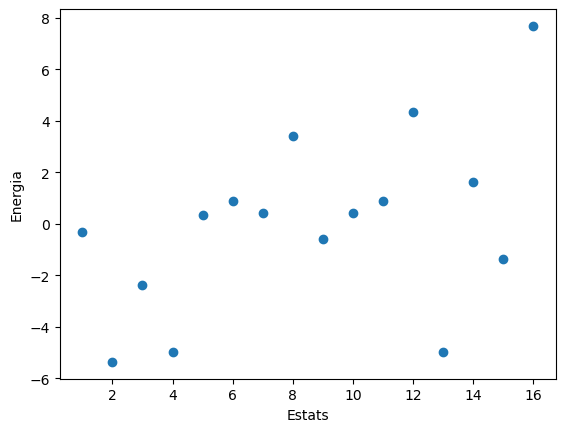

Energia mínima:  -5.361333585539793 Corresponent al ground-state:  2 que és:  [-1. -1. -1.  1.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
#Declarem les matrius de Pauli i la identitat
sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.array([[1,0],[0,-1]])
identitat = np.identity(2)

#Calculem les energies del ground state, H0

#Operador Hamiltonià H0
def Ham0():
    H = np.zeros((2**N, 2**N))

    #Afegim el terme alpha
    for i in range(N):
        malpha = np.identity(1)
        for j in range(N):
            if j == i:
                malpha = np.kron(malpha, sigma_z)
            else:
                malpha = np.kron(malpha, identitat)
        H -= alpha*malpha

    #Afegim el terme J
    for i in range(N-1):
        for j in range(i,N):
            mJ = np.identity(1)
            for k in range(N):
                if k == i:
                    mJ = np.kron(mJ, sigma_z)
                elif k == j:
                    mJ = np.kron(mJ, sigma_z)
                else:
                    mJ = np.kron(mJ, identitat)
            H -= matrix_J[i,j]*mJ
    return H

H0 = Ham0()

#Calculem les energies del ground state, H0
vals_H0, vecs_H0 = np.linalg.eigh(H0)

print ("Energies de l'estat inicial: ", vals_H0)
print ("Vectors propis de l'estat inicial: ", vecs_H0)
#Trobem un anàleg de l'ordre de les energies amb els estats corresponents
ordre = []
for i in range(2**N):
    num = np.where(vecs_H0[:,i] == 1)[0][0]
    ordre.append(num)


#Grafiquem l'energia H0 per tots els estats possibles
#En un eix el nombre d'estat i en l'altre l'energia
ordremes1 = [i+1 for i in ordre]
plt.plot(ordremes1, vals_H0, "o")
plt.xlabel('Estats')
plt.ylabel('Energia')
plt.show()

print("Energia mínima: ", vals_H0[0], "Corresponent al ground-state: ", ordremes1[0], "que és: ", estats_spins[ordre[0]])

E_min = vals_H0[0]

#Guardem el vector propi corresponent a l'estat amb energia mínima
vec_minH0 = vecs_H0[:,0]
print (vec_minH0)


### Operador Hamiltonià temporal

Com s'ha anunciat al principi, l'operador hamiltonià de la nostra simulació també tindrà un terme que evolucionarà amb el temps. Serà de la forma:

$$ \mathcal{H}(t)=\mathcal{H}_0-\Gamma(t) \sum_i \sigma_i^x $$
on:
$$ \mathcal{H}_0=-\sum_{i,j} J_{i j} \sigma_i^z \sigma_j^z-\alpha \sum_i \sigma_i^z$$

És molt importnant escollir una funció $\Gamma (t)$ que avanci de forma prou lenta com perquè el sistema no salti entre el ground state i els primers excitats. El sistema ha d'evolucionar de forma adiabàtica. Per exemple, nosaltres farem servir:

$$ \Gamma (t) = \frac{10}{1+t}$$


In [7]:


#Operador Hamiltonià
def H(t):
    H = np.zeros((2**N, 2**N))

    #Afegim el terme alpha
    for i in range(N):
        malpha = np.identity(1)
        for j in range(N):
            if j == i:
                malpha = np.kron(malpha, sigma_z)
            else:
                malpha = np.kron(malpha, identitat)
        H -= alpha*malpha

    #Afegim el terme J
    for i in range(N-1):
        for j in range(i,N):
            mJ = np.identity(1)
            for k in range(N):
                if k == i:
                    mJ = np.kron(mJ, sigma_z)
                elif k == j:
                    mJ = np.kron(mJ, sigma_z)
                else:
                    mJ = np.kron(mJ, identitat)
            H -= matrix_J[i,j]*mJ

    #Afegim el terme gamma
    gamma = 10./(t+1.)
    for i in range(N):
        mgamma = np.identity(1)
        for j in range(N):
            if j == i:
                mgamma = np.kron(mgamma, sigma_x)
            else:
                mgamma = np.kron(mgamma, identitat)
        H -= gamma*mgamma

    return H

H0 = H(0)

#Diagonalitzem H0 per obtenir els valors propis i els vectors propis
valors_propis, vectors_propis = np.linalg.eigh(H0)

print("Energies:", valors_propis)


#Guardem l'estat propi del ground state al temps inicial
ground_state = vectors_propis[:,0]

print("Estat inicial:", ground_state)


Energies: [-40.35667119 -23.09406967 -20.70630486 -18.86065173 -18.10464009
  -3.38861268  -2.31362361   0.36709731   0.64546318   1.92573709
   2.7050888   17.46070361  19.64755315  21.36761389  22.29004623
  40.41527057]
Estat inicial: [0.27079761 0.29735177 0.27305087 0.28337935 0.25380387 0.24159053
 0.24241111 0.21824858 0.25996635 0.24482505 0.24009066 0.21391419
 0.27811147 0.2269354  0.24322261 0.18784153]


### Evolució temporal

Per a veure com avança el Hamiltonià amb el temps, haurem de simular l'Equació d'Schrödinger depenent del temps (ESDT). Això ho farem mitjançant el mètode de Crank-Nicolson, un mètode numèric de diferències finites per a resoldre equacions en derivades parcials.

\begin{equation}
i \frac{\partial|\phi(t)\rangle}{\partial t}=\mathcal{H}(t)|\phi(t)\rangle
\end{equation}

 Primer de tot buscarem una aproximació de l'estat $|\phi(t+\Delta t / 2)\rangle$ una com a semipas endavant des de $t$.
\begin{equation}
 \frac{\partial|\phi(t)\rangle}{\partial t} \approx 2i\frac{\phi \left( t + \Delta t/2\right) - \phi(t)}{\Delta t } 
 \hspace{0.5cm} \xrightarrow{ESDT} \hspace{0.5cm}
 \left|\phi\left(t+\frac{\Delta t}{2}\right)\right\rangle=\left(1-\frac{i \Delta t}{2} \mathcal{H}\right)|\phi(t)\rangle
\end{equation}

Farem el mateix però com un semipas enrere des de $t + \Delta t$.

\begin{equation}
\left|\phi\left(t+\frac{\Delta t}{2}\right)\right\rangle=\left(1+\frac{i \Delta t}{2} \mathcal{H}\right)|\phi(t+\Delta t)\rangle
\end{equation}

Igualem les dues expressions i obtenim:

\begin{equation}
\left(1+i \frac{\Delta t}{2 \hbar} \hat{H}\right) \phi(t+\Delta t)=\left(1-i \frac{\Delta t}{2 \hbar} \hat{H}\right) \phi(t)
\end{equation}

\begin{equation}
|\phi(t+\Delta t)\rangle=\left(1+i \frac{\Delta t}{2} \mathcal{H}\right)^{-1}\left(1-i \frac{\Delta t}{2} \mathcal{H}\right)|\phi(t)\rangle
\end{equation}

Per tant, el problema a resoldre serà:

\begin{equation}
\hat{A} \vec{\Psi}(x, t+\Delta t)=\vec{b}
\end{equation}

On tots els $\mathcal{H} = \mathcal{H}(t)$. Considerarem $\Gamma_1=10 /(t+1)$. \\

El nostre estat inicial serà l'estat de mínima energia de l'Hamiltonià depenent del temps a l'instant inicial


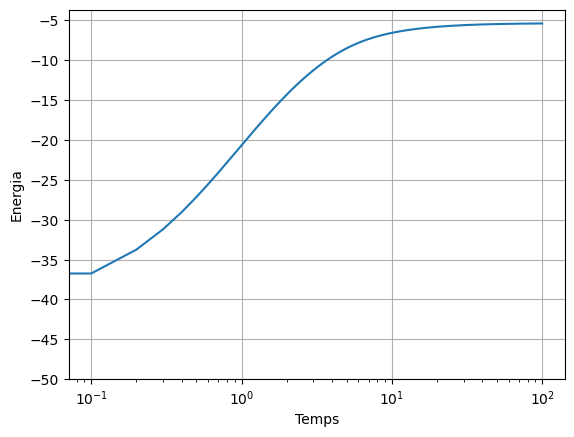

Energia final: -5.3902977705821105
Valor teòric: -5.361333585539793


In [8]:
#Crank-Nicolson per a la resolució de l'equació de Schrödinger en el temps

psi = ground_state
psi = psi/np.linalg.norm(psi) #Normalitzem

#Definim el temps inicial i final
t_inicial = 0
t_final = 100
dt = 0.1

#Definim el temps
temps = np.arange(t_inicial, t_final, dt)
vect_energy = []


productes_escalars = []

for t in temps:
    #Definim les matrius de propagació
    U_mes = np.identity(2**N) + 1j*dt/2.*H(t)
    U_menys = np.identity(2**N) - 1j*dt/2.*H(t)

    #Fem un pas de temps dt
    psi = np.linalg.solve(U_mes, np.dot(U_menys, psi))

    #Calculem l'energia
    energia = np.real(np.dot(np.conjugate(psi), np.dot(H(t), psi)))
    vect_energy.append(energia)

    #Calculem el producte escalar entre psi i el vector propi del ground state
    producte_escalar = np.linalg.norm((np.dot(np.conjugate(psi), vec_minH0)))**2
    productes_escalars.append(producte_escalar)

#Grafiquem l'energia en funció del temps amb l'eix x en escala logarítmica
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale('log')
plt.plot(temps, vect_energy)
plt.yticks(np.arange(-50,0,5))
plt.xlabel('Temps')
plt.ylabel('Energia')
plt.grid()
plt.ylim = (-40,0)
plt.show()

#Mostrem el valor final de l'energia
print("Energia final:", vect_energy[-1])
print("Valor teòric:", E_min)

Veiem que l'energia avança cap al ground-state. 

Una altra forma de comprovar si estem realitzant un procés adiabàtic és amb el producte escalar entre el vector propi del groundstate i el nostre vector. Idelment hauria d'avançar cap a 1.

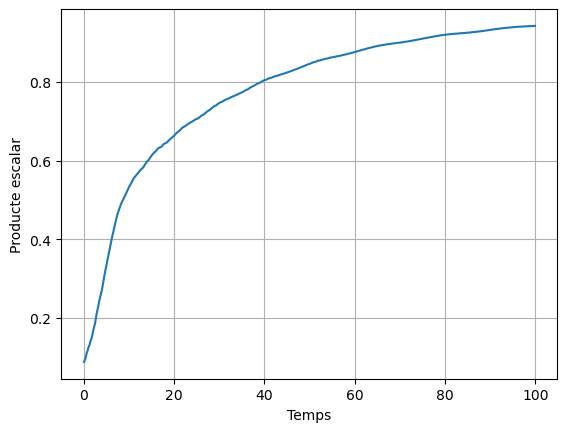

In [9]:
#Grafiquem els productes escalars en funció del temps
plt.plot(temps, productes_escalars)
plt.xlabel('Temps')
plt.ylabel('Producte escalar')
plt.grid()
plt.show()


## SIMULACIÓ DEL PROBLEMA DEL COMERCIANT AMB QUANTUM ANNEALING

Per simular el problema, haurem d'expressar el problema del comerciant com un Hamiltonià d'on volem trobar l'estat de mínima energia.
El problema del comerciant (en anglès: Travelling salesman problem) es pot enunciar de la següent forma: _Un comerciant ha de passar per N ciutats, de forma que només vol passar un cop per cada lloc, i vol trobar la ruta més curta. Aquesta ruta ha d'acabar a la mateixa ciutat on ha començat._

Matemàticament, podem formular el problema minimitzant la funció:

\begin{equation} 
    d = \sum_{i=1}^n \sum_{j \neq i, j=1}^n c_{i j} x_{i j}
\end{equation}

On d és la distància total del recorregut, $x_{ij}$ val 1 si les ciutats $i$ i $j$ estan connectades i 0 en cas contrari. Finalment, el coeficient $c_{ij}$ és el cost, normalment distància o temps, d'utlitzar el camí de la ciutat i a la j. Per tant, la funció sumarà totes les distàncies dels recorreguts entre nodes del recorregut proposat, ja que només pondera aquelles que $x_{ij} = 1$.

### Formulació QUBO del problema
 A partir de la formulació per grafs que hem plantejat, podem traduïr el problema a un Hamiltonià d'un Ising model, que després tindrà un anàleg amb qubits. Cal notar que hi ha moltes formes d'expressar aquest problema amb formulació Ising, ja que no és senzill traduïr les restriccions del problema com a parts del sumatori. En aquest punt presentarem una de les més senzilles d'entendre però difícilment traduïble a quantum annealing.

 Primer de tot, podem expressar les restriccions de no passar dos cops per la mateixa ciutat com:

\begin{aligned}
H_A =  A \sum_{v=1}^n\left(1-\sum_{j=1}^N x_{v, j}\right)^2+A \sum_{j=1}^n\left(1-\sum_{v=1}^N x_{v, j}\right)^2
 % +A \sum_{(u v) \notin E} \sum_{j=1}^N x_{u, j} x_{v, j+1} .
\end{aligned}


Que suposa una penalització d'energia de l'ordre de la constant $A>0$ si alguna s'incompleix. Els dos primers termes imposen que no passis dos cops per una ciutat, en cap de les dues direccions, ja que si només hi passes un cop, $\left(1-\sum_{j=1}^N x_{v, j}\right)^2 = 0$ i no hi ha la penalització energètica. 


La part del Hamiltonià que ens expressi la distància total recorreguda la podem expressar de forma anàloga a l'equació de la distància.

\begin{equation}
H_B=B \sum_{(u v) \in E} W_{u v} \sum_{j=1}^N x_{u, j} x_{v, j+1} .
\end{equation}

Finalment, el Hamiltonià total que haurem de traduir al nostre quantum annealer serà:

\begin{equation}
    H = H_A + H_B
\end{equation}

### De QUBO a ISING

Les variables en una formulació QUBO poden prendre els valors de 0 o 1. En canvi, en una formulació ISING poden prendre els valors de -1 o 1. Per a fer la transformació entre aquestes dues formulacions equivalents hem de tenir en compte que:

$$ x_{I,i} = 2x_{Q,i}-1  \xRightarrow{} x_Q = \frac{x_I+1}{2}$$

On $x_I$ són les variables en la formulació ISING i $x_Q$ en formulació QUBO. Per a traslladar-ho al sistema físic de qubits ens interessarà tenir el problema expressat com un ISING.

Les constants que ens apareixin tindran implícita una multiplicació per una Identitat de dimensió $2^N * 2^N$ on N és el nombre de ciutats del nostre problema.

### Aleatoritzem les ciutats

Per a plantejar el problema primer ens caldrà tenir la posició de les N ciutats que conformin el nostre problema. En el nostre cas ho farem en un mapa de dimensions 100x100.


Ciutats: [[13.5, 36.2], [30.0, 27.1], [41.4, 39.6]]


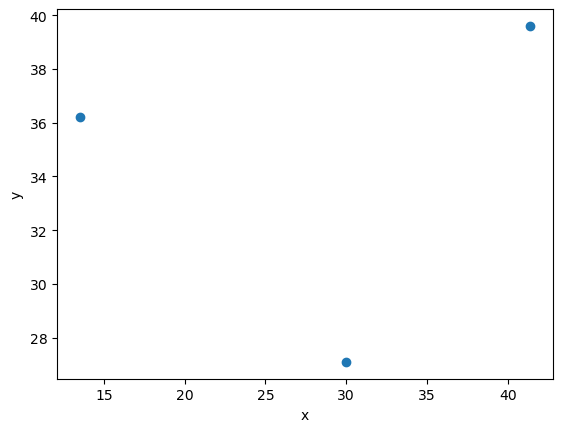

In [11]:
#Aleatoritzem les ciutats
x_mapa = 100
y_mapa = 100

# number of cities
N_ciutats = 3
n = N_ciutats
nombre_ciutats = N_ciutats

#Generem les coordenades x,y de les ciutats
x = np.random.randint(0, x_mapa*10, n)
x = x/10.
y = np.random.randint(0, y_mapa*10, n)
y = y/10.

#Ho posem tot a una llista
cities = []
for i in range(n):
    cities.append([x[i], y[i]])

print("Ciutats:", cities)

#Les representem en un gràfic
plt.plot(x, y, "o")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Matriu de distàncies
Per el nostre hamiltonià, ens caldrà tenir els coeficients de distància entre tots els nodes del graf (distàncies entre ciutats). Per a facilitar la definició de l'operador més endavant, ho podrem expressar en una matriu $W$, on $W_{ij}$ serà la distància entre la ciutat i i la ciutat j.

Distàncies: [[5.00000000e+04 1.88430358e+01 2.81064050e+01]
 [1.88430358e+01 5.00000000e+04 1.69177422e+01]
 [2.81064050e+01 1.69177422e+01 5.00000000e+04]]


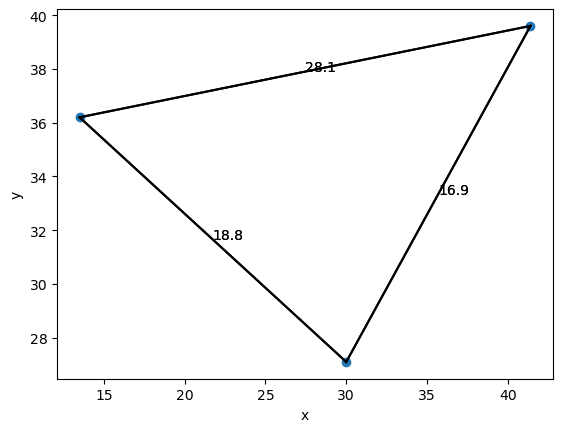

In [12]:
distancies = np.zeros((n,n))

#Calculem les distàncies entre totes les ciutats
for i in range(n):
    for j in range(n):
        distancies[i,j] = np.sqrt((x[i]-x[j])**2 + (y[i]-y[j])**2)
        if i == j:
            distancies[i,j] = 50000

print("Distàncies:", distancies)

#Fem un mapa de les ciutats amb les distàncies a les arestes
plt.plot(x, y, "o")
for i in range(n):
    for j in range(n):
        if i != j:
            plt.plot([x[i], x[j]], [y[i], y[j]], "k")
            plt.text((x[i]+x[j])/2., (y[i]+y[j])/2., str(round(distancies[i,j],1)))
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Resolució clàssica del problema per força bruta
La primera forma que un pensa per a resoldre el problema de forma unívoca és provar totes les possibilitats i triar la millor, la que té la distància més petita i uneix totes les ciutats sense repetir-ne cap. El problema d'aquesta possibilitat és que el seu cost computacional escala molt ràpidament per a cada nova ciutat que afegim. Això passa perquè el nombre de possibilitats $M$ augmenta de forma factorial, ja que $M = N!$ on N és el nombre de ciutats.

Per exemple, per a només 10 ciutats haurem de fer $10! = 3628800$ iteracions per a trobar la resposta.

Permutació amb distància mínima: [2, 1, 0]
Distància mínima: 63.86718297895602


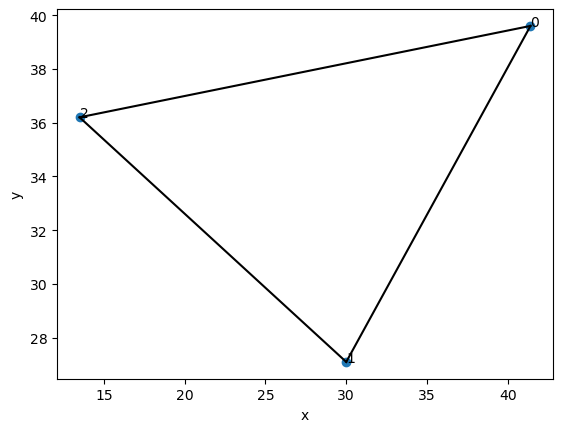

In [13]:
#Resolució per força bruta
#Generem totes les permutacions possibles
for i in range(n):
    if i == 0:
        permutacions = [[i]]
    else:
        permutacions_aux = []
        for cas in permutacions:
            for j in range(len(cas)+1):
                permutacions_aux.append(cas[:j]+[i]+cas[j:])
        permutacions = permutacions_aux

#Calculem la distància de cada permutació
distancies_permutacions = []
for cas in permutacions:
    dist = 0
    for i in range(n):
        dist += distancies[cas[i],cas[(i+1)%n]]
    distancies_permutacions.append(dist)

#Agafem la permutació amb la distància mínima
min_dist = min(distancies_permutacions)
min_perm = permutacions[distancies_permutacions.index(min_dist)]

print("Permutació amb distància mínima:", min_perm)
print("Distància mínima:", min_dist)

#Representem la permutació amb la distància mínima
plt.plot(x, y, "o")
for i in range(n):
    plt.text(x[i], y[i], str(min_perm[i]))
for i in range(n):
    plt.plot([x[min_perm[i]], x[min_perm[(i+1)%n]]], [y[min_perm[i]], y[min_perm[(i+1)%n]]], "k")
plt.xlabel('x')
plt.ylabel('y')
plt.show()


### Diferents formulacions ising de les combinacions

En aquest apartat farem una mica de combinatoria per a explorar les possibles solucions del problema abans d'aplicar les restriccions. Per tant, estudiarem totes les combinacions amb repetició dels $1,2,...,n$ nodes, que seran $n^n$ possibilitats. Les restriccions que ens imposaran que el camí estigui tancat i no es repeteixin els nodes, ens reduïran aquest nombre a $n!$ com hem dit abans. 

Ho haurem de fer d'aquesta forma, ja que per a traduïr el problema a spins ens caldrà a aquesta forma general.

In [14]:
#Possibles combinacions amb repeticio de n ciutats [1,1,1,1,...,1,1], [1,1,1,1,...,1,2], [1,1,1,1,...,1,3], ... , [n,n,n,n,...,n,n]

combinacions = n**n
permutacions = []
for i in range(combinacions):
    permutacions.append([i%n+1])   
    for j in range(n-1):
        permutacions[i].append(int(i/(n**(j+1)))%n+1)

print("Combinacions amb repetició de les " + str(n) + " ciutats:")
permutacions.sort()
for i in range(combinacions):
    print(permutacions[i])

#Podem asignar a cada estat un valor binari en un vector de n**n posicions
#Per exemple, [1,1,1,...,1,1] -> [1,0,0,...,0,0]; [1,1,1,...,1,2] -> [0,1,0,...,0,0]; [1,1,1,...,1,3] -> [0,0,1,...,0,0]; ... ; [n,n,n,...,n,n] -> [0,0,0,...,0,1]
permutacions_binari = np.zeros((combinacions, combinacions))
permutacions_binari = np.eye(combinacions)

print("")
print("Assignant una coordenada a cada possible estat:")
for i in permutacions_binari:
    print(i)

Combinacions amb repetició de les 3 ciutats:
[1, 1, 1]
[1, 1, 2]
[1, 1, 3]
[1, 2, 1]
[1, 2, 2]
[1, 2, 3]
[1, 3, 1]
[1, 3, 2]
[1, 3, 3]
[2, 1, 1]
[2, 1, 2]
[2, 1, 3]
[2, 2, 1]
[2, 2, 2]
[2, 2, 3]
[2, 3, 1]
[2, 3, 2]
[2, 3, 3]
[3, 1, 1]
[3, 1, 2]
[3, 1, 3]
[3, 2, 1]
[3, 2, 2]
[3, 2, 3]
[3, 3, 1]
[3, 3, 2]
[3, 3, 3]

Assignant una coordenada a cada possible estat:
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.

### Variables (Spins) necessaris en funció del nombre de ciutats
Ara estudiarem el nombre de variables, i per tant de spins, en les que es traduïran les nostres variables $x_{ij}$. També visualitzarem la dimensió de la matriu quadrada que representarà el sistema i amb la que haurem d'operar.

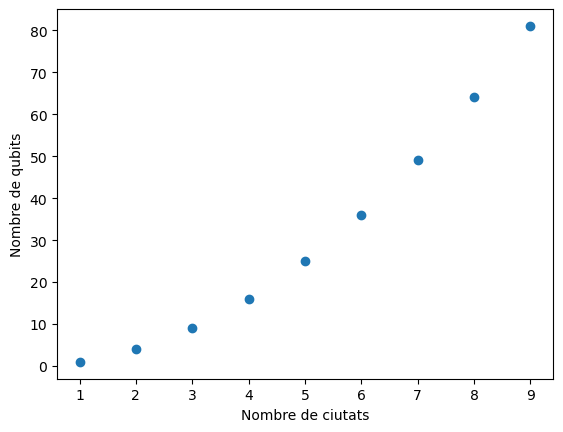

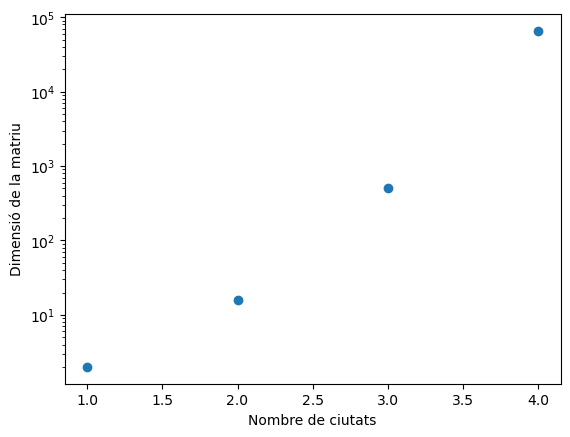

In [15]:
#Grafiquem el nombre de variables x_{jk} en funció de les ciutats
def nombre_variables(nombre_ciutats):
    return nombre_ciutats**2

x = np.arange(1, 10, 1)
y = nombre_variables(x)
plt.plot(x, y, "o")
plt.xlabel('Nombre de ciutats')
plt.ylabel('Nombre de qubits')
plt.show()

#Grafiquem la dimensió de la matriu en funció del nombre de ciutats
#Farem servir escala logarítmica
def dimensio_matriu(nombre_ciutats):
    return 2**(nombre_ciutats**2)

x = np.arange(1, 5, 1)
y = dimensio_matriu(x)
plt.plot(x, y, "o")
plt.xlabel('Nombre de ciutats')
plt.ylabel('Dimensió de la matriu')
plt.yscale('log')
plt.show()



### Possibles estats dels spins

Amb la funció que hem programat al principi, veurem els possibles estats, ara en la formulació dels spins. Estaran ordenats de la mateixa forma que les combinacions amb repetició dels N nodes.

In [16]:

#Farem servir la funcio matriu_estats per generar la combinacio 
#de les n**2 variables x_{ij} que correspon a cada estat
#Aquesta funcio ens retorna una matriu de 2**n**2 files i n**2 columnes

estats_spins_tsp = matriu_estats(n**2)

for estat in estats_spins_tsp:
    print(estat)

[-1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1. -1. -1.  1.]
[-1. -1. -1. -1. -1. -1. -1.  1. -1.]
[-1. -1. -1. -1. -1. -1. -1.  1.  1.]
[-1. -1. -1. -1. -1. -1.  1. -1. -1.]
[-1. -1. -1. -1. -1. -1.  1. -1.  1.]
[-1. -1. -1. -1. -1. -1.  1.  1. -1.]
[-1. -1. -1. -1. -1. -1.  1.  1.  1.]
[-1. -1. -1. -1. -1.  1. -1. -1. -1.]
[-1. -1. -1. -1. -1.  1. -1. -1.  1.]
[-1. -1. -1. -1. -1.  1. -1.  1. -1.]
[-1. -1. -1. -1. -1.  1. -1.  1.  1.]
[-1. -1. -1. -1. -1.  1.  1. -1. -1.]
[-1. -1. -1. -1. -1.  1.  1. -1.  1.]
[-1. -1. -1. -1. -1.  1.  1.  1. -1.]
[-1. -1. -1. -1. -1.  1.  1.  1.  1.]
[-1. -1. -1. -1.  1. -1. -1. -1. -1.]
[-1. -1. -1. -1.  1. -1. -1. -1.  1.]
[-1. -1. -1. -1.  1. -1. -1.  1. -1.]
[-1. -1. -1. -1.  1. -1. -1.  1.  1.]
[-1. -1. -1. -1.  1. -1.  1. -1. -1.]
[-1. -1. -1. -1.  1. -1.  1. -1.  1.]
[-1. -1. -1. -1.  1. -1.  1.  1. -1.]
[-1. -1. -1. -1.  1. -1.  1.  1.  1.]
[-1. -1. -1. -1.  1.  1. -1. -1. -1.]
[-1. -1. -1. -1.  1.  1. -1. -1.  1.]
[-1. -1. -1.

## HAMILTONIÀ DEL TSP

### Formulacio Zhang et al.
De totes les possibles formulacions, algunes ja presentades anteriorment, n'hem escollit una que ja estava en la forma desitjada de les matrius de Pauli. L'hem trobada al paper _Solving Traveling Salesman Problems Using
Ising Models with Simulated Bifurcation_ (Tingting Zhang, Qichao Tao, Jie Han).

$$H_{t s p}=  \frac{A}{4} \sum_{k \neq l} \sum_i W_{k l} \sigma_{i k} \sigma_{(i+1) l}+\frac{A}{2} \sum_{k \neq l} \sum_i W_{k l} \sigma_{i k} +\frac{B}{4} \sum_i \sum_k \sum_l \sigma_{i k} \sigma_{i l}+\frac{(n-2) B}{2} \sum_i \sum_k \sigma_{i k} +\frac{C}{4} \sum_i \sum_k \sum_j \sigma_{i k} \sigma_{j k}+\frac{(n-2) C}{2} \sum_i \sum_k \sigma_{i k}$$

En aquesta formulació, els operadors $\sigma_{ik}$ correspondran a l'spin de la variable $x_{ik}$ que serà 1 si la ciutat k es visita a la iteració i.

Arribats aquí, només caldrà repetir exactament el mateix procediment que hem fet anteriorment amb el problema aleatori, però tenint en compte que estem simulant un nombre molt elevat d'spins que es tradueïx en unes matrius molt grans. Això fa que algunes coses no puguin funcionar o el codi trigui molt en executar.

In [17]:
#Formulacio Zhang et al.
#Declarem les matrius de Pauli i la identitat
sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.array([[1,0],[0,-1]])
identitat = np.identity(2)

N_spins = N_ciutats**2

print(N_ciutats)
print(N_spins)
print(2**N_spins)

def Hamiltonia0_tsp(A, B, C):
    H0 = np.zeros((2**N_spins, 2**N_spins))
    for k in range(N_ciutats):
        for l in range(N_ciutats):
            for i in range(N_ciutats):
                
                if k != l:

                    matrix1 = np.identity(1)
                    for j in range(N_ciutats):
                        for t in range(N_ciutats):
                            if (j == k) and (t == i):
                                matrix1 = np.kron(matrix1, sigma_z)
                            elif (j == l) and (t == i+1):
                                matrix1 = np.kron(matrix1, sigma_z)
                            else:
                                matrix1 = np.kron(matrix1, identitat)
                    H0 += A*matrix1*distancies[k,l]/4.


                    matrix2 = np.identity(1)
                    for j in range(N_ciutats):
                        for t in range(N_ciutats):
                            if (j == k) and (t == i):
                                matrix2 = np.kron(matrix2, sigma_z)
                            else:
                                matrix2 = np.kron(matrix2, identitat)
                    H0 += A*matrix2*distancies[k,l]/2.

                    matrix3 = np.identity(1)
                    for j in range(N_ciutats):
                        for t in range(N_ciutats):
                            if (j == k) and (t == i):
                                matrix3 = np.kron(matrix3, sigma_z)
                            elif (j == l) and (t == i):
                                matrix3 = np.kron(matrix3, sigma_z)
                            else:
                                matrix3 = np.kron(matrix3, identitat)
                    H0 += B*matrix3/4.

                    matrix5 = np.identity(1)
                    for j in range(N_ciutats):
                            for t in range(N_ciutats):
                                if (j == k) and (t == i):
                                    matrix5 = np.kron(matrix5, sigma_z)
                                elif (j == k) and (t == l):
                                    matrix5 = np.kron(matrix5, sigma_z)
                                else:
                                    matrix5 = np.kron(matrix5, identitat)
                    H0 += C*matrix5/4.


    for i in range(N_ciutats):
        for k in range(N_ciutats):

            matrix4 = np.identity(1)
            for j in range(N_ciutats):
                for t in range(N_ciutats):
                    if (j == k) and (t == i):
                        matrix4 = np.kron(matrix4, sigma_z)
                    else:
                        matrix4 = np.kron(matrix4, identitat)


            H0 += (N_ciutats-2)*B*matrix4/2.

            matrix6 = np.identity(1)
            for j in range(N_ciutats):
                for t in range(N_ciutats):
                    if (j == k) and (t == i):
                        matrix6 = np.kron(matrix6, sigma_z)
                    else:
                        matrix6 = np.kron(matrix6, identitat)
            H0 += (N_ciutats-2)*C*matrix6/2.
        


        
    return H0

3
9
512


### Energia dels estats

Podem visualitzar l'energia de tots els possibles estats dels spins, igual que hem fet abans. Això ens permetrà veure el resultat al que la simulació hauria d'arribar abans de fer córrer la simulació.

Comprovarem que, degut a la complexitat del problema, l'estat que troba no és una de les possibles solucions del sistema. Això pot ser per algun error en la formulació del sistema, de programació o de traducció de l'estat trobat al camí entre les ciutats. Tanmateix, el codi ens permet veure com traduirïem un problema d'Ising al procediment del QA.

Energies de l'estat inicial:  [-3.05540831e+03 -3.05540831e+03 -3.05444567e+03 -3.05444567e+03
 -3.04981398e+03 -3.04981398e+03 -2.62486983e+03 -2.62294453e+03
 -2.62023814e+03 -2.61735020e+03 -2.60904948e+03 -2.60808683e+03
 -2.60698944e+03 -2.60506414e+03 -2.60139511e+03 -2.60043246e+03
 -2.59772607e+03 -2.59676342e+03 -2.59483813e+03 -2.59387548e+03
 -2.59116909e+03 -2.59020644e+03 -2.58653741e+03 -2.58461211e+03
 -2.58447736e+03 -2.58158942e+03 -2.58158942e+03 -2.57984568e+03
 -2.57984568e+03 -2.57599509e+03 -2.56306268e+03 -2.56306268e+03
 -2.55829625e+03 -2.55155772e+03 -2.53591893e+03 -2.53303099e+03
 -2.15966796e+03 -2.15966796e+03 -2.15966796e+03 -2.14178757e+03
 -2.14178757e+03 -2.13715588e+03 -2.13619324e+03 -2.13619324e+03
 -2.12390718e+03 -2.12390718e+03 -2.11464381e+03 -2.11464381e+03
 -2.11271852e+03 -2.10602679e+03 -2.09213174e+03 -2.09213174e+03
 -2.08924380e+03 -2.08924380e+03 -2.08814640e+03 -2.08447736e+03
 -2.07792039e+03 -2.07792039e+03 -2.07599509e+03 -2.07328870

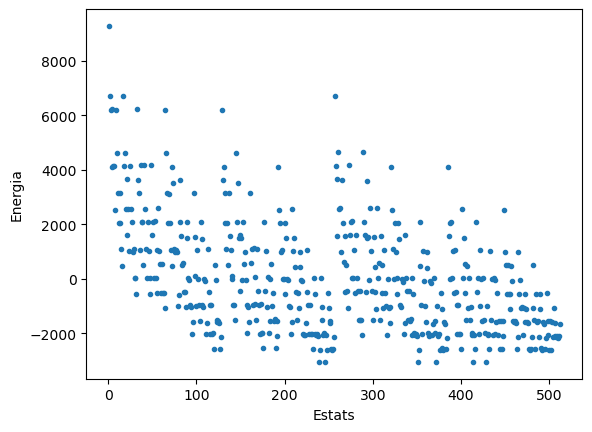

Energia mínima:  -3055.408311895886 Corresponent al ground-state:  239 que és:  [-1.  1.  1.  1. -1.  1.  1.  1. -1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.

In [18]:
#Paràmetres per ajustar la importància de les restriccions a l'hamiltonià
A = 1
B = 500
C = 500

H0 = Hamiltonia0_tsp(A, B, C)

#Calculem les energies del ground state, H0
vals_H0, vecs_H0 = np.linalg.eigh(H0)

print ("Energies de l'estat inicial: ", vals_H0)
print ("Vectors propis de l'estat inicial: ", vecs_H0) 
for i in vecs_H0:
    print (i)
    


#Trobem un anàleg de l'ordre de les energies amb els estats corresponents
ordre = []
for i in range(2**N_spins):
    num = np.where(vecs_H0[:,i] == 1)[0][0]
    ordre.append(num)


#Grafiquem l'energia H0 per tots els estats possibles
#En un eix el nombre d'estat i en l'altre l'energia
ordremes1 = [i+1 for i in ordre]
plt.plot(ordremes1, vals_H0, "o", markersize = 3)
plt.xlabel('Estats')
plt.ylabel('Energia')

#Guardem la figura en png
plt.savefig('Energies_H0.png', dpi = 300)
plt.show()

print("Energia mínima: ", vals_H0[0], "Corresponent al ground-state: ", ordremes1[0], "que és: ", estats_spins_tsp[ordre[0]])

E_min = vals_H0[0]

#Guardem el vector propi corresponent a l'estat amb energia mínima
vec_minH0 = vecs_H0[:,0]
print (vec_minH0)

Observem que, malauradament, l'estat de mínima energia no és solució del probelma del comerciant. Això pot ser degut a un error en la formulació, en la interpretació de l'equació o en la traducció de l'estat trobat a spins. També pot ser algun altre tipus d'error degut a la complexitat del problema.

In [19]:
#Afegim el terme gamma
def H_gamma(t):
    gamma = 10./(t+1.)

    Hgamma = np.zeros((2**N_spins, 2**N_spins))
    for i in range(N_ciutats):
        for j in range(N_ciutats):
            
            mgamma = np.identity(1)
            for k in range(N_ciutats):
                for l in range(N_ciutats):
                    if k == i and l == j:
                        mgamma = np.kron(mgamma, sigma_x)
                    else:
                        mgamma = np.kron(mgamma, identitat)
            Hgamma += gamma*mgamma
    return gamma*mgamma




In [20]:
A = 1
B = 1000
C = 1000


#Definim l'hamiltonià total
def Hamiltonia_tsp(A, B, C, t):
    return Hamiltonia0_tsp(A, B, C) + H_gamma(t)

print(Hamiltonia_tsp(A, B, C, 0))

[[ 1.82874023e+04  1.00000000e+01  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+01  1.31973540e+04  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.21973540e+04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.15966796e+03
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -4.11464381e+03  1.00000000e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   1.00000000e+01 -3.15966796e+03]]


In [21]:

H0_TSP = Hamiltonia_tsp(A,B,C,0)

#Diagonalitzem H0 per obtenir els valors propis i els vectors propis
valors_propis, vectors_propis = np.linalg.eigh(H0_TSP)

print("Energies:", valors_propis)


#Guardem l'estat propi del ground state al temps inicial
ground_energy_TSP = np.amin(valors_propis)
ordre = np.argsort(valors_propis)

ground_state_TSP = vectors_propis[:,ordre[0]]

print ("Energia propia del ground state:", ground_energy_TSP)
print("Estat propi del ground state:", ground_state_TSP)

Energies: [-6.05551490e+03 -6.05545721e+03 -6.05449416e+03 -6.05449390e+03
 -6.04992186e+03 -6.04986288e+03 -5.12699093e+03 -5.12283666e+03
 -5.12181254e+03 -5.11724361e+03 -5.11039224e+03 -5.11020794e+03
 -5.10703834e+03 -5.10515732e+03 -5.10144400e+03 -5.10052814e+03
 -5.09783266e+03 -5.09686812e+03 -5.09493381e+03 -5.09396964e+03
 -5.09127379e+03 -5.09025534e+03 -5.08664528e+03 -5.08466101e+03
 -5.08452586e+03 -5.08168358e+03 -5.08168260e+03 -5.07995227e+03
 -5.07772457e+03 -5.07608925e+03 -5.06317056e+03 -5.06094158e+03
 -5.05672185e+03 -5.05165188e+03 -5.03457616e+03 -5.03307988e+03
 -4.16178906e+03 -4.15956137e+03 -4.15956008e+03 -4.14168287e+03
 -4.14168098e+03 -4.13927699e+03 -4.13608853e+03 -4.13608536e+03
 -4.12400286e+03 -4.12400134e+03 -4.11474851e+03 -4.11281420e+03
 -4.11252271e+03 -4.10736955e+03 -4.09322888e+03 -4.09081820e+03
 -4.09001063e+03 -4.08933948e+03 -4.08819464e+03 -4.08451020e+03
 -4.07949478e+03 -4.07796928e+03 -4.07608827e+03 -4.07540981e+03
 -4.07366882e+0

### Simulació amb Cranck-Nicolson

Podem fer avançar l'Hamiltonià fins al ground-state igual que hem fet abans amb el mètode de Crank-Nicolson:


\begin{equation}
i \frac{\partial|\phi(t)\rangle}{\partial t}=\mathcal{H}(t)|\phi(t)\rangle
\end{equation}

 Primer de tot buscarem una aproximació de l'estat $|\phi(t+\Delta t / 2)\rangle$ una com a semipas endavant des de $t$.
\begin{equation}
 \frac{\partial|\phi(t)\rangle}{\partial t} \approx 2i\frac{\phi \left( t + \Delta t/2\right) - \phi(t)}{\Delta t } 
 \hspace{0.5cm} \xrightarrow{ESDT} \hspace{0.5cm}
 \left|\phi\left(t+\frac{\Delta t}{2}\right)\right\rangle=\left(1-\frac{i \Delta t}{2} \mathcal{H}\right)|\phi(t)\rangle
\end{equation}

Farem el mateix però com un semipas enrere des de $t + \Delta t$.

\begin{equation}
\left|\phi\left(t+\frac{\Delta t}{2}\right)\right\rangle=\left(1+\frac{i \Delta t}{2} \mathcal{H}\right)|\phi(t+\Delta t)\rangle
\end{equation}

Igualem les dues expressions i obtenim:

\begin{equation}
\left(1+i \frac{\Delta t}{2 \hbar} \hat{H}\right) \phi(t+\Delta t)=\left(1-i \frac{\Delta t}{2 \hbar} \hat{H}\right) \phi(t)
\end{equation}

\begin{equation}
|\phi(t+\Delta t)\rangle=\left(1+i \frac{\Delta t}{2} \mathcal{H}\right)^{-1}\left(1-i \frac{\Delta t}{2} \mathcal{H}\right)|\phi(t)\rangle
\end{equation}

Per tant, el problema a resoldre serà:

\begin{equation}
\hat{A} \vec{\Psi}(x, t+\Delta t)=\vec{b}
\end{equation}

On tots els $\mathcal{H} = \mathcal{H}(t)$. Considerarem $\Gamma_1=10 /(t+1)$. \\

El nostre estat inicial serà l'estat de mínima energia de l'Hamiltonià depenent del temps a l'instant inicial



Observarem que per una matriu d'aquestes dimensions, el cost computacional de la simulació és molt gran.



Temps: 0.0 Energia: -6055.514902987844 Producte escalar: 0.9998863962984214
Temps: 0.1 Energia: -6055.495524990969 Producte escalar: 0.9998863963121887
Temps: 0.2 Energia: -6055.479376661315 Producte escalar: 0.9998863963605656
Temps: 0.30000000000000004 Energia: -6055.465712693562 Producte escalar: 0.9998863964561493
Temps: 0.4 Energia: -6055.454000727607 Producte escalar: 0.9998863966063614
Temps: 0.5 Energia: -6055.443850366508 Producte escalar: 0.9998863968153081
Temps: 0.6000000000000001 Energia: -6055.434968812798 Producte escalar: 0.9998863970849433
Temps: 0.7000000000000001 Energia: -6055.427132162637 Producte escalar: 0.999886397415812
Temps: 0.8 Energia: -6055.420166268622 Producte escalar: 0.9998863978075366
Temps: 0.9 Energia: -6055.413933645949 Producte escalar: 0.9998863982591402
Temps: 1.0 Energia: -6055.408324306731 Producte escalar: 0.9998863987692616
Temps: 1.1 Energia: -6055.403249213075 Producte escalar: 0.9998863993363022
Temps: 1.2000000000000002 Energia: -6055.39

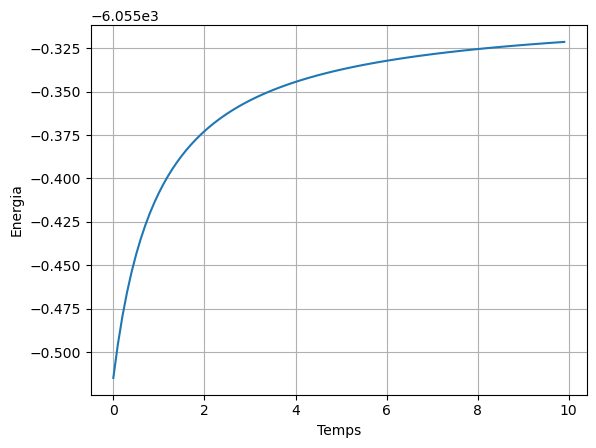

In [22]:
#Afegim un terme ortogonoal que evolucioni amb el temps
#Per tal de fer la simulació de quantum annealing
#Crank-Nicolson per a la resolució de l'equació de Schrödinger en el temps

psi = ground_state_TSP
psi = psi/np.linalg.norm(psi) #Normalitzem

#Definim el temps inicial i final
t_inicial = 0
t_final = 10
dt = 0.1

#Definim el temps
temps = np.arange(t_inicial, t_final, dt)
vect_energy = []


productes_escalars = []


for t in temps:
    #Definim les matrius de propagació
    U_mes = np.identity(2**N_spins) + 1j*dt/2.*Hamiltonia_tsp(A,B,C,t)
    U_menys = np.identity(2**N_spins) - 1j*dt/2.*Hamiltonia_tsp(A,B,C,t)

    #Fem un pas de temps dt
    psi = np.linalg.solve(U_mes, np.dot(U_menys, psi))

    #Calculem l'energia
    energia = np.real(np.dot(np.conjugate(psi), np.dot(Hamiltonia_tsp(A,B,C,t), psi)))
    vect_energy.append(energia)

    #Calculem el producte escalar entre psi i el vector propi del ground state
    producte_escalar = np.linalg.norm((np.dot(np.conjugate(psi), vec_minH0)))**2
    productes_escalars.append(producte_escalar)

    print("Temps:", t, "Energia:", energia, "Producte escalar:", producte_escalar)

#Grafiquem l'energia en funció del temps amb l'eix x en escala logarítmica
fig = plt.figure() 
ax = fig.add_subplot(111)
#ax.set_xscale('log')
plt.plot(temps, vect_energy)
#plt.yticks(np.arange(-50,0,5))
plt.xlabel('Temps')
plt.ylabel('Energia')
plt.grid()
#plt.ylim = (-40,0)
plt.show()



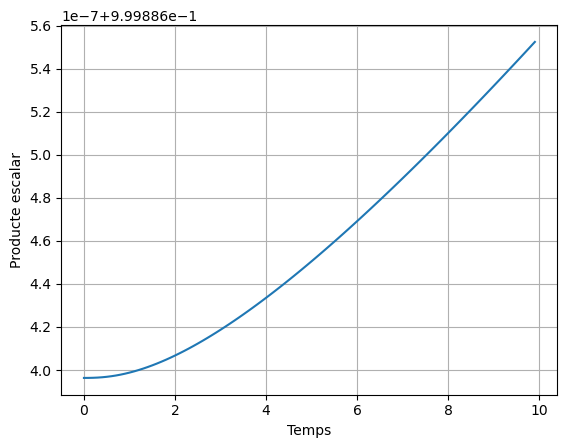

In [23]:
#Grafiquem els productes escalars en funció del temps
plt.plot(temps, productes_escalars)
plt.xlabel('Temps')
plt.ylabel('Producte escalar')
plt.grid()
plt.show()


## REFERÈNCIES

Quantum Annealing in the transverse Ising Model, Óscar Promio MuÑnoz